In [77]:
import torch
from math import exp
from random import random
from torch.distributions.normal import Normal

import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import pandas as pd
from scipy.stats import wasserstein_distance
from numpy.polynomial.polynomial import Polynomial

In [85]:
Polynomial((0, 1))(np.array([1, 2, 3]))

array([1., 2., 3.])

In [2]:
# normal = torch.distributions.normal.Normal(0, 1)

In [7]:
Normal(0,1).sample([5])

tensor([ 0.7021,  0.6400, -1.1283, -0.2330,  1.2684])

In [86]:
class MetropolisHastings:
    """
    Metropolis Hastings algorithm for sampling from a distribution p

    Attributes
    ----------
    p : distribution to sample from
    q : proposal distribution
    prev : previous sample
    """
    def __init__(self, p, q):
        self.p = p
        self.q = q
        self.prev = None
        self.samples = []
    
    def _acceptance_prob(self, x):
        a = self.p.log_prob(x) + self.q.log_prob(self.prev, x) - self.p.log_prob(self.prev) - self.q.log_prob(x, self.prev)
        a = min(1, exp(a))
        return a        

    def _step(self):
        # Sample from q
        x = self.q.sample()
        
        # Compute acceptance probability
        a = self._acceptance_prob(x)
        if a >= 1 or random() < a:
            self.prev = x

    def sample(self, n, x0, burnin=0):
        self.prev = x0
        for i in range(burnin):
            self._step()

        for i in range(n):
            self._step()
            self.samples.append(self.prev)
        return self.samples

    def _trace_plot(self, ax):
        ax.plot(self.samples)
    
    def _autocorrelation_plot(self, ax):
        ax.acorr(self.samples)

    def _wasserstein_distance_plot(self, ax, window_width = 100):
        target_samples = self.p.sample([len(self.samples)])

        w_dists = []
        for i in range(0 , len(self.samples) - window_width + 1, window_width):
            w_dists.append(wasserstein_distance(self.samples[i:i+window_width], target_samples[i:i+window_width]))
        
        x_arr = np.arange(window_width - 1, len(self.samples), window_width)
        ax.plot(x_arr, w_dists)

        # quadratic fit
        poly = Polynomial.fit(x_arr, w_dists, 2)
        ax.plot(x_arr, poly(x_arr))


        

In [87]:
class IndependentGaussianProposal:
    def __init__(self, mu, sigma):
        self.normal = Normal(mu, sigma)

    def log_prob(self, x, param=None):
        return self.normal.log_prob(x)
    
    def sample(self):
        return self.normal.sample()

In [88]:
MH = MetropolisHastings(Normal(0, 1), IndependentGaussianProposal(0, 1))
MH.sample(30000, torch.tensor(0));

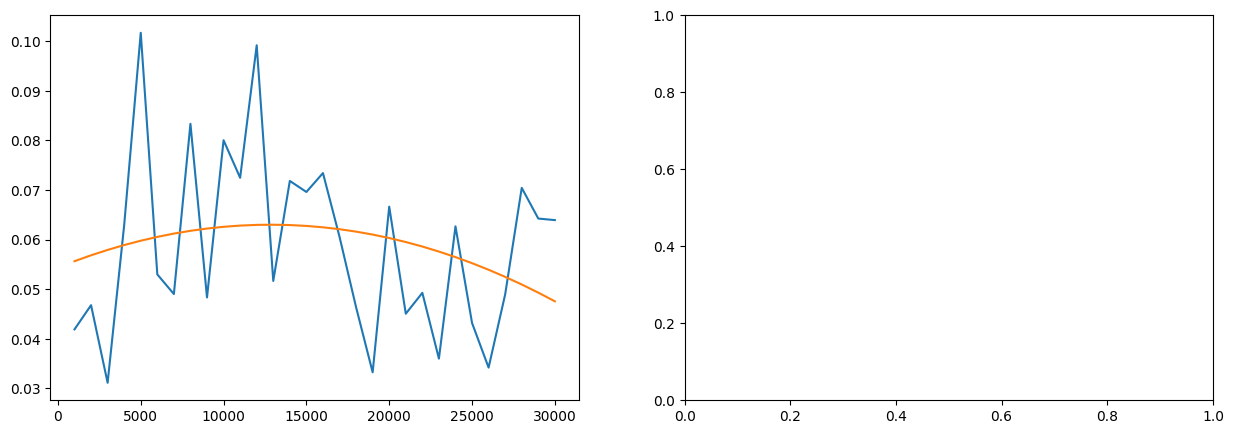

In [103]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
MH._wasserstein_distance_plot(axs[0], window_width=1000)

In [106]:
MH2 = MetropolisHastings(Normal(0, 1), IndependentGaussianProposal(0, 0.75))
MH2.sample(30000, torch.tensor(0));

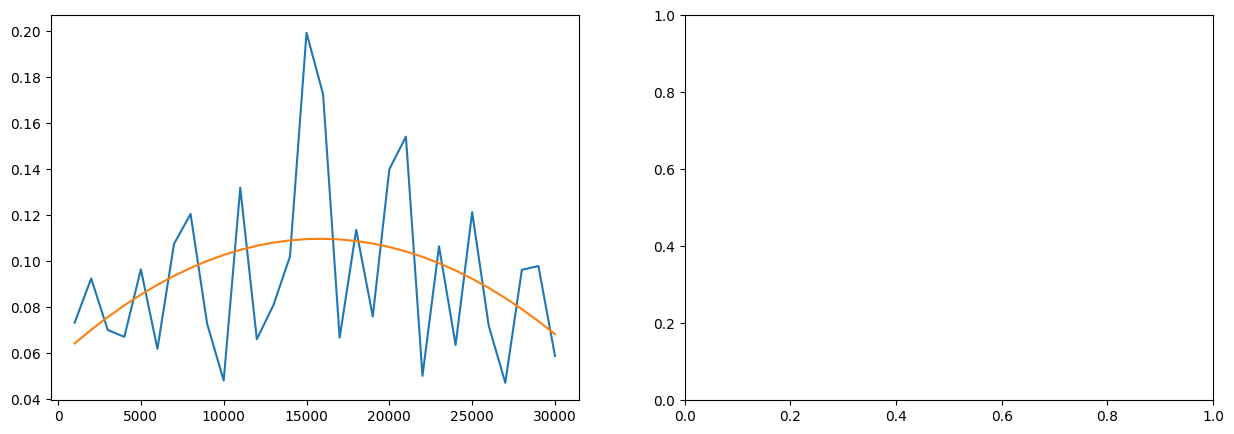

In [107]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
MH2._wasserstein_distance_plot(axs[0], window_width=1000)

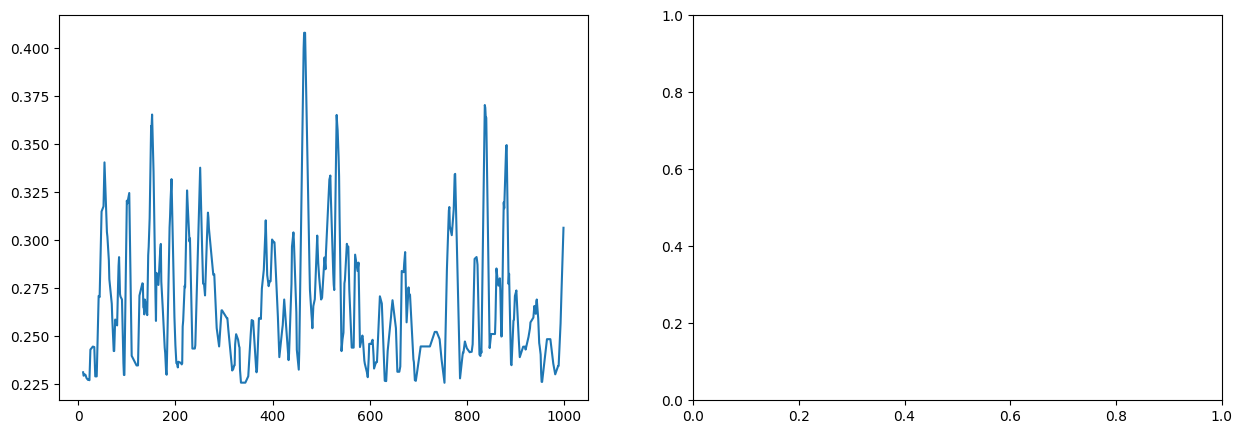

In [61]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
MH._KL_plot(axs[0])

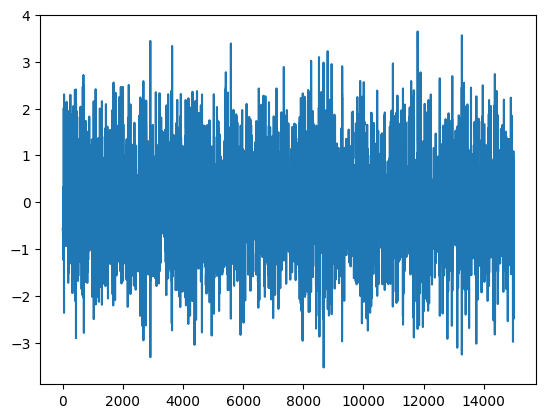

In [16]:
MH._trace_plot()

In [30]:
cumsum_vec = np.cumsum(np.insert(MH.samples, 0, 0)) 
window_width = 100
ma_vec = (cumsum_vec[window_width:] - cumsum_vec[:-window_width]) / window_width
print(ma_vec.shape)

(14901,)


In [33]:
MH.samples.__len__()

15000

(array([-20, -19, -18, -17, -16, -15, -14, -13, -12, -11, -10,  -9,  -8,
         -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,   3,   4,   5,
          6,   7,   8,   9,  10,  11,  12,  13,  14,  15,  16,  17,  18,
         19,  20]),
 array([0.00221519, 0.00889229, 0.00926426, 0.01330447, 0.01756509,
        0.01979456, 0.02275612, 0.0230877 , 0.0201591 , 0.02835713,
        0.03788247, 0.05086517, 0.06455982, 0.08309   , 0.11363754,
        0.1573724 , 0.22305977, 0.32598737, 0.4766404 , 0.6938037 ,
        1.        , 0.6938037 , 0.4766404 , 0.32598737, 0.22305977,
        0.1573724 , 0.11363754, 0.08309   , 0.06455982, 0.05086517,
        0.03788247, 0.02835713, 0.0201591 , 0.0230877 , 0.02275612,
        0.01979456, 0.01756509, 0.01330447, 0.00926426, 0.00889229,
        0.00221519], dtype=float32),
 <matplotlib.lines.Line2D at 0x1ab5b457c40>)

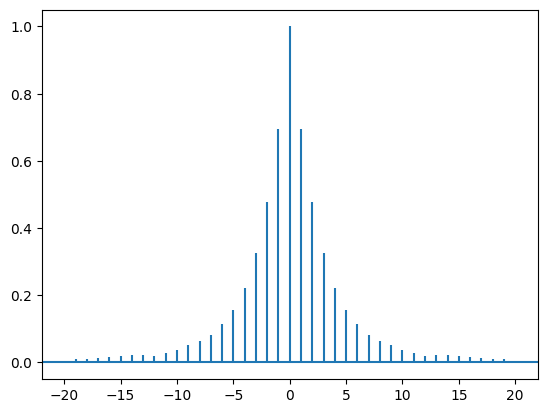

In [11]:
plt.acorr(MH.samples, maxlags=20)

(array([-20, -19, -18, -17, -16, -15, -14, -13, -12, -11, -10,  -9,  -8,
         -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,   3,   4,   5,
          6,   7,   8,   9,  10,  11,  12,  13,  14,  15,  16,  17,  18,
         19,  20]),
 array([0.42904493, 0.44748226, 0.46648836, 0.4870512 , 0.5086917 ,
        0.53270525, 0.5575662 , 0.5832066 , 0.6079841 , 0.6341606 ,
        0.6612056 , 0.6903728 , 0.72140056, 0.7529821 , 0.78497756,
        0.8172255 , 0.8516216 , 0.8863572 , 0.9218288 , 0.96024305,
        1.        , 0.96024305, 0.9218288 , 0.8863572 , 0.8516216 ,
        0.8172255 , 0.78497756, 0.7529821 , 0.72140056, 0.6903728 ,
        0.6612056 , 0.6341606 , 0.6079841 , 0.5832066 , 0.5575662 ,
        0.53270525, 0.5086917 , 0.4870512 , 0.46648836, 0.44748226,
        0.42904493], dtype=float32),
 <matplotlib.lines.Line2D at 0x1ab5a327e80>)

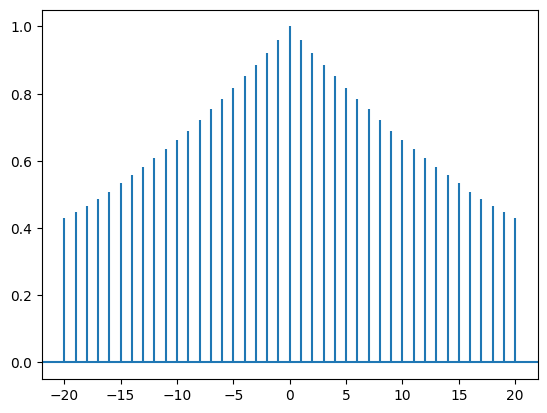

In [8]:
plt.acorr(MH.samples, maxlags=20)

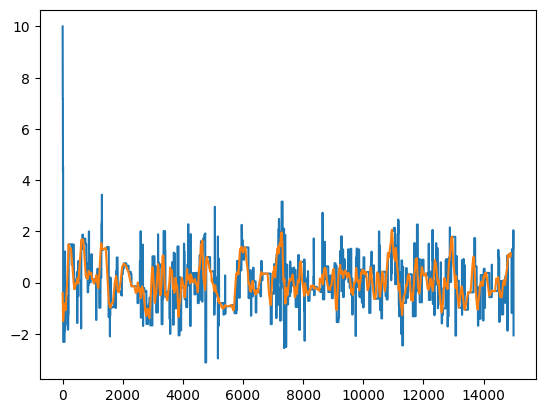

In [12]:
plt.plot(MH.samples)
plt.plot(ma_vec)

In [18]:
KL= - Normal(0, 1).log_prob(torch.tensor(MH.samples))
KL_cumsum = np.cumsum(KL)
mean_KL = (KL_cumsum[window_width:] - KL_cumsum[:-window_width]) / window_width

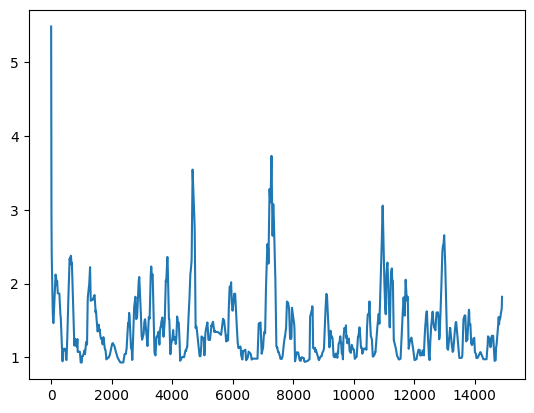

In [19]:
plt.plot(mean_KL)

In [148]:
MH._acceptance_prob(torch.tensor(1))

0.9455132167348842

(array([0.064537  , 0.        , 0.        , 0.        , 0.38722181,
        0.12907394, 0.32268484, 0.        , 0.32268484, 0.12907394,
        0.38722181, 0.8389806 , 0.38722181, 1.0325915 , 0.12907394,
        1.16166544, 0.8389806 , 0.90351757, 1.8715721 , 0.90351757,
        1.871573  , 0.64536938, 1.16166488, 0.774444  , 1.871573  ,
        1.8715712 , 1.61342345, 0.96805407, 2.58148248, 0.90351713,
        0.77444326, 1.22620418, 0.83898019, 0.5162955 , 0.19361081,
        0.90351713, 0.32268531, 1.67796039, 0.38722163, 0.12907412,
        0.        , 0.45175857, 0.        , 0.06453694, 0.        ,
        0.32268469, 0.12907437, 0.        , 0.        , 0.25814775]),
 array([-0.35376367, -0.32277369, -0.29178369, -0.26079369, -0.22980371,
        -0.19881372, -0.16782373, -0.13683374, -0.10584375, -0.07485376,
        -0.04386377, -0.01287378,  0.01811621,  0.0491062 ,  0.08009619,
         0.11108617,  0.14207616,  0.17306615,  0.20405614,  0.23504613,
         0.26603612,  0.29

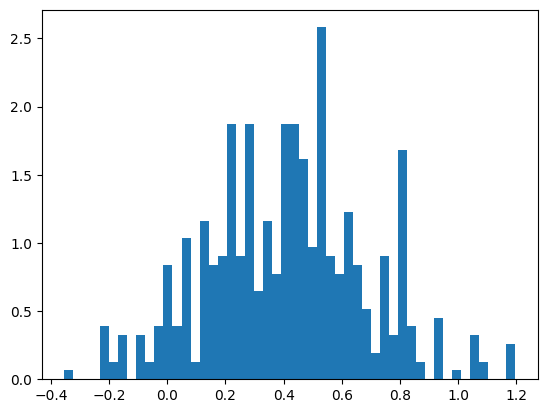

In [93]:
plt.hist(MH.samples, density=True, bins=50)

burnin

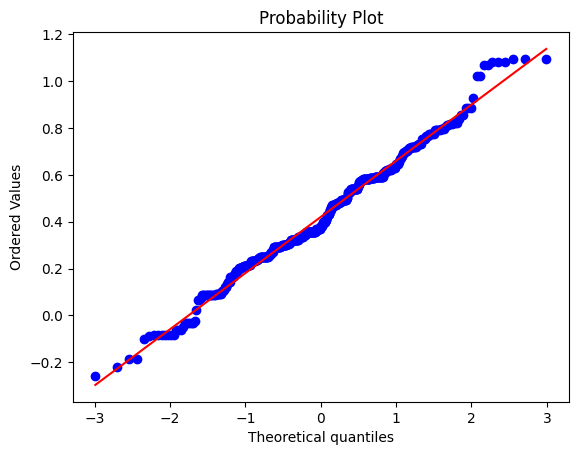

In [91]:
stats.probplot(MH.samples, dist="norm", plot=plt);

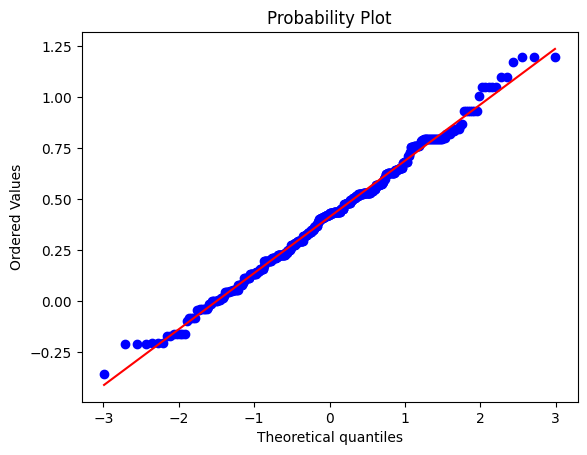

In [94]:
stats.probplot(MH.samples, dist="norm", plot=plt);

In [50]:
MH = MetropolisHastings(torch.distributions.exponential.Exponential(1), IndependentGaussianProposal(0, 1))
MH.sample(1000, torch.tensor(1.))

ValueError: Expected value argument (Tensor of shape ()) to be within the support (GreaterThanEq(lower_bound=0.0)) of the distribution Exponential(rate: 1.0), but found invalid values:
-0.6608418226242065